In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from torchmetrics.functional import r2_score as r2_loss
from sklearn.model_selection import train_test_split
from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
import sys 
import os
import random
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torchmetrics import MeanSquaredError
# from pytorch_lightning import LightningModule, Trainer
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

sys.path.append(os.path.dirname(os.getcwd())) 
from source.autoencoder import VariationalAutoencoder

### Simulate time series with intervals 
Now time series array of train data consists of 3 parts: mean values of daily incidence, low valuee of daily incidence and high values of daily incidence for each day. Therefore, the size of time series array is three times bigger than tmax -- number of simulation days. 

In [6]:
df = pd.read_csv('../data/network_model_interval_dataset_72.csv', index_col=0)
tmax = int((df.values.shape[1] - 5)/3) # number of simulation days
# 5 - number of parameters of the network model
df['ts'] = df[['incidence_' + str(day_index) for day_index in range(tmax)] + \
              ['low_incidence_' + str(day_index) for day_index in range(tmax)] + \
              ['high_incidence_' + str(day_index) for day_index in range(tmax)]].values.tolist()
data = df[['beta', 'alpha', 'ts']]

In [7]:
print(r'Диапазон параметров beta:[{}, {}], alpha:[{}, {}]'.format(df['beta'].min(), df['beta'].max(),
                                                                             df['alpha'].min(),
                                                                             df['alpha'].max()))

Диапазон параметров beta:[0.1, 0.9], alpha:[0.2, 0.9000000000000002]


In [8]:
X_train, X_test, y_train, y_test =  train_test_split(data.drop(columns=['ts']), 
                                                     data.ts.values, 
                                                     test_size=0.33, 
                                                     random_state=42)
X_train, X_test = X_train.values, X_test.values

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)

In [10]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [12]:
def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred, _, _ = model(custom_data_tensor)
    return pred.detach().cpu()

In [13]:
def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

In [14]:
def warmup_loss(epoch, n_epochs, criterion, steps, pred, mu, logvar, gt, use=True):
    if use:
        if epoch/n_epochs < steps:
            loss = criterion(pred ,gt)
        else:
            mse_loss = criterion(pred, gt)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = mse_loss + kl_loss
    else:
        loss = criterion(pred, gt)

    return loss

In [15]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [16]:
def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    tb = SummaryWriter()

    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred, mu, logvar = model(X_batch.to(device))

            loss = warmup_loss(epoch, n_epochs, criterion, 0, pred, mu, logvar, y_batch.to(device), use=False)

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

        tb.add_scalar("Total loss", loss.item(), epoch)
    tb.close()

In [17]:
hidden_size = 512
latent_size = 256
n_epochs = 50

mse_cr = F.mse_loss
r2_cr = r2_loss
vae = VariationalAutoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=3*tmax).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=5e-4)

In [18]:
lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-6)

In [19]:
train(vae, n_epochs, train_loader, mse_cr, optimizer, lr_sched)

100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


In [20]:
test(vae, X_test, y_test)

R2 Score: -0.004091071585814158


In [44]:
def plot_test_with_intervals(params, gt, fontsize=14):
    gt = np.array(gt)
    mean_index = range(tmax)
    low_index = range(tmax, 2*tmax)
    high_index = range(2*tmax, 3*tmax)
    surrogate_sim = predict(vae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt[mean_index], label='Network model', marker='o', color='OrangeRed')
    ax.fill_between(np.linspace(0, tmax, tmax), gt[low_index], gt[high_index],
                    alpha = 0.5, color='OrangeRed', label='Network model interval')
    ax.plot(surrogate_sim[mean_index], lw=3, color='RoyalBlue', label='Surrogate model')
    ax.fill_between(np.linspace(0, tmax, tmax), 
                    surrogate_sim[low_index], 
                    surrogate_sim[high_index],
                    alpha = 0.5, color='RoyalBlue', label='Surrogate model interval')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

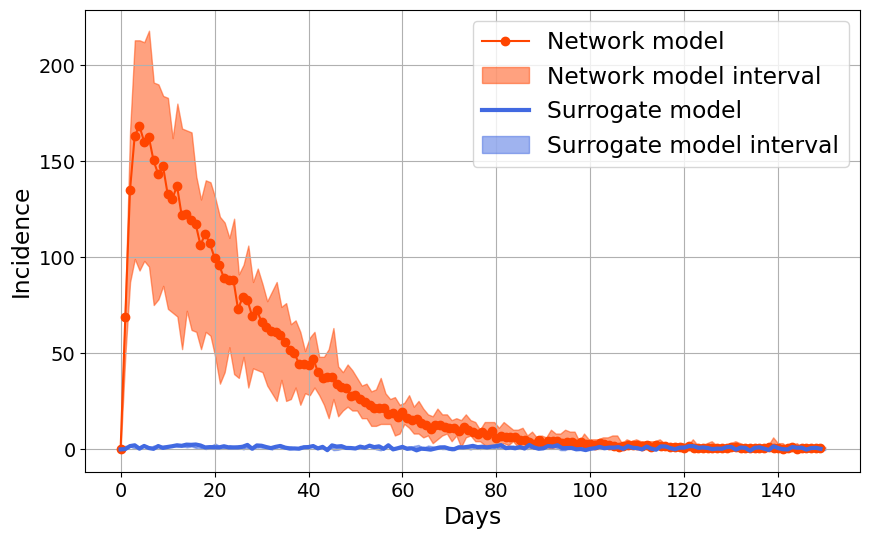

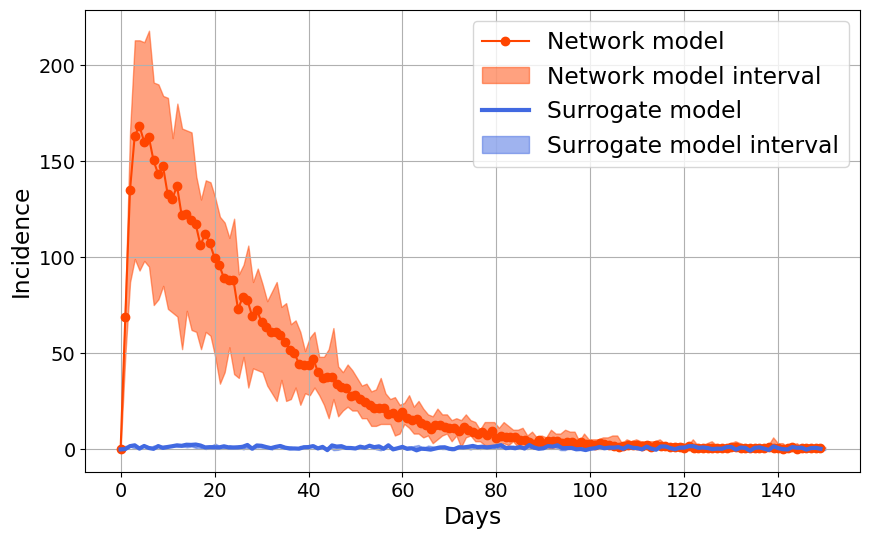

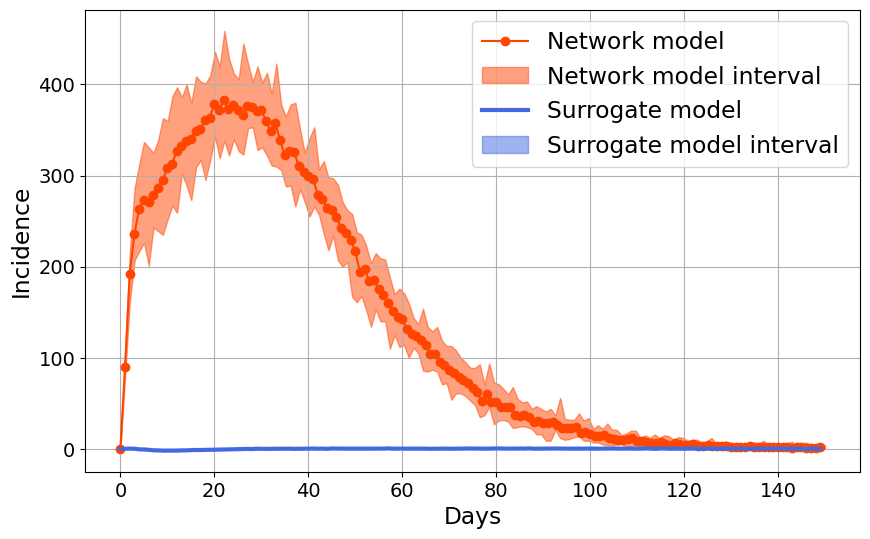

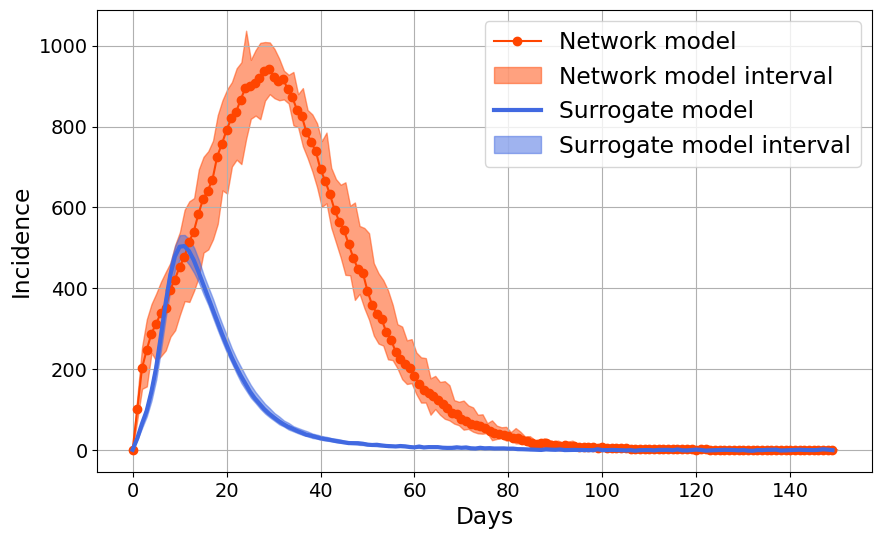

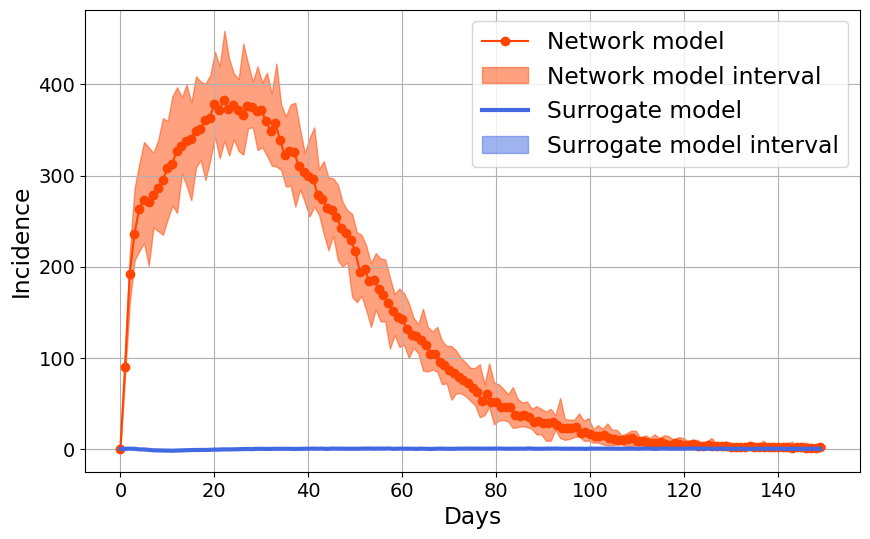

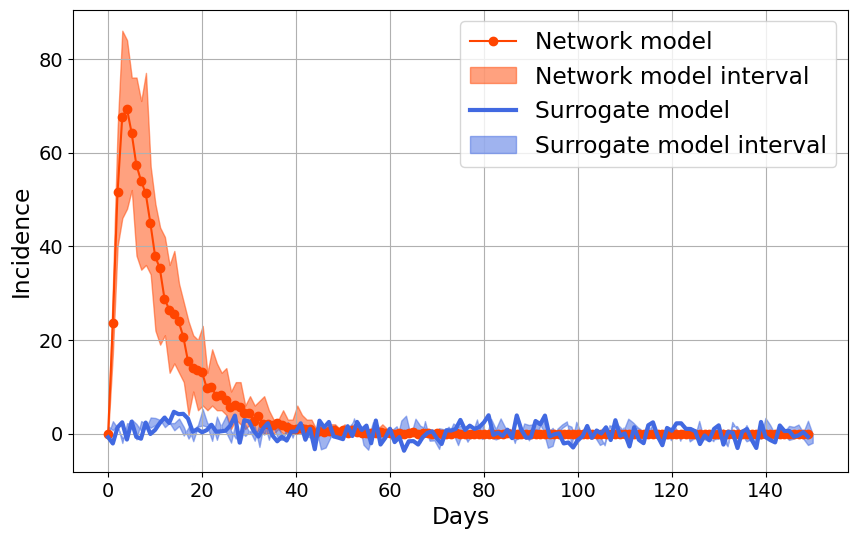

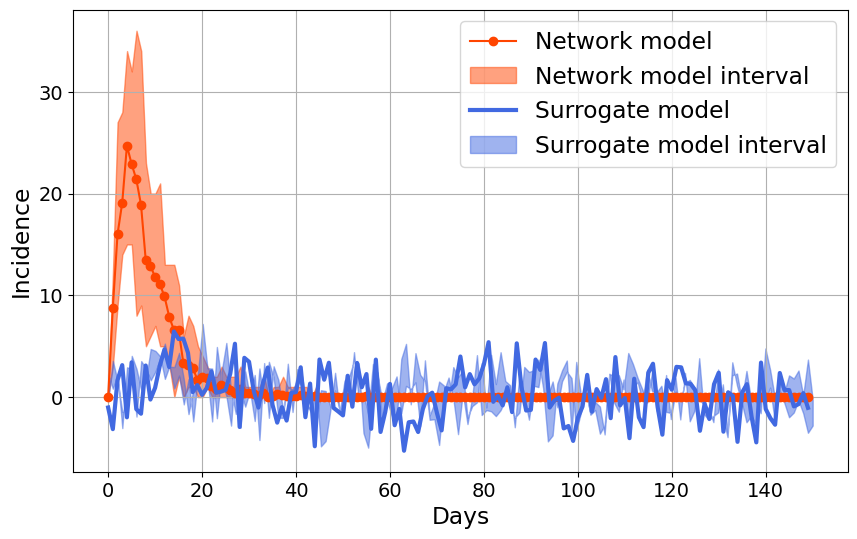

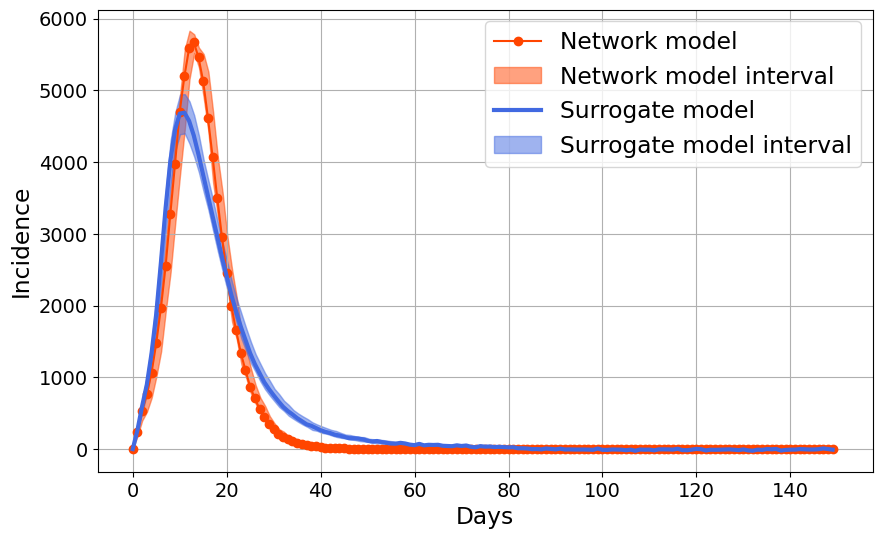

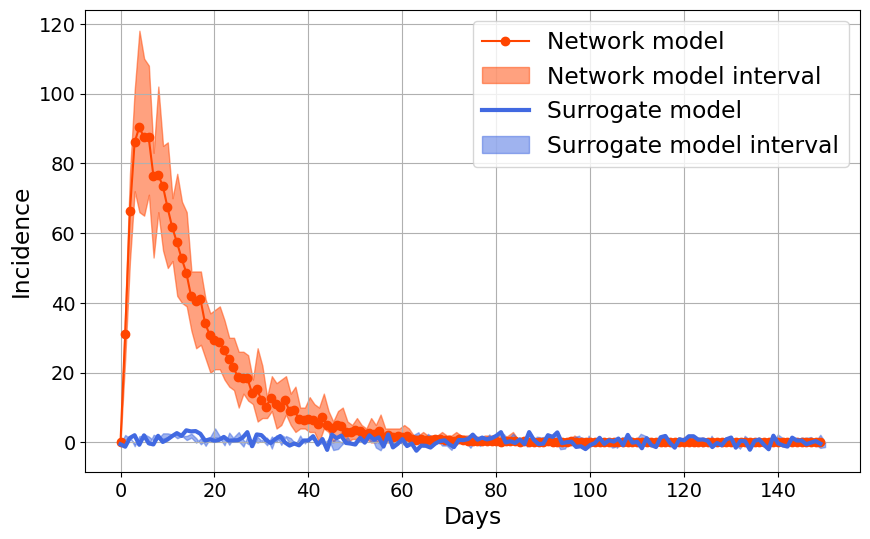

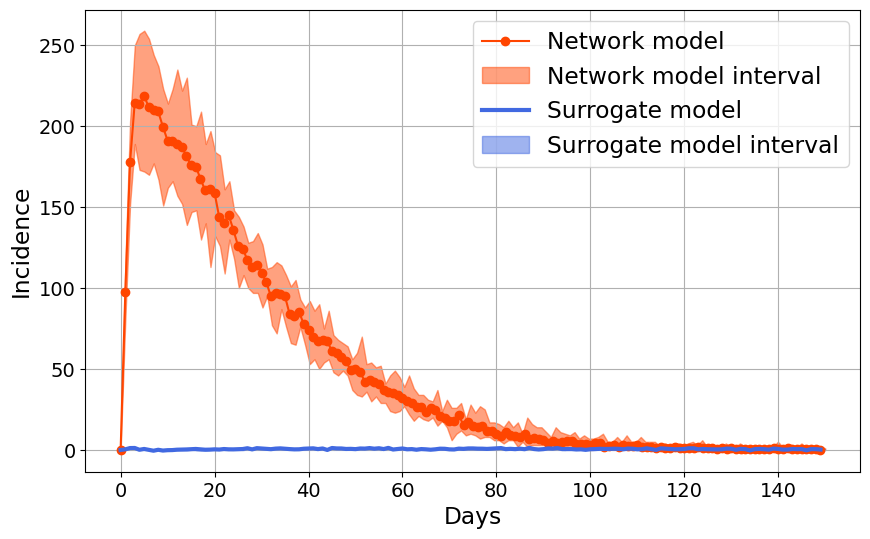

In [45]:
for _ in range(10):
    index = random.randint(0, len(y_test)-1)
    fig = plot_test_with_intervals(X_test[index], y_test[index])
    fig.savefig(r'../figures/surrogate_interval_{}.png'.format(index), dpi=600,
                bbox_inches='tight')